## Simple implementation of Score-based Generative Modeling through SDEs by Song and Ermon (2021)

$\newcommand\myeq{\stackrel{\text{def}}{=}}$
$\newcommand{\zb}{\mathbf{z}}$
$\newcommand{\qb}{\mathbf{q}}$
$\newcommand{\wb}{\mathbf{w}}$
$\newcommand{\sb}{\mathbf{s}}$
$\newcommand{\thetab}{\mathbf{\theta}}$
$\newcommand{\xb}{\mathbf{x}}$
$\newcommand{\xpb}{\mathbf{x}'}$
$\newcommand{\bb}{\bar{\beta}}$

[Song et al. (2021)](https://arxiv.org/pdf/2011.13456)

Here we start by defining the VE and VP SDEs used on the half-moons dataset.

## **VE SDE**


The forward diffusion SDE for VE is given by (21) in the paper from the Markov chain $\xb_i = \xb_{i-1} + \sqrt{\sigma_i^2 - \sigma_{i-1}^2}\zb_{i-1}$:

$$d\xb = \sqrt{\frac{d[\sigma^2(t)]}{dt}}d\wb$$

In practice this is given by $\sigma(t) = \sigma_\min(\frac{\sigma_\max}{\sigma_\min})^{\frac{i}{N-1}}$ for $t \in (0,1]$. (This is given in part C of the paper.


### Marginal prob (forward process)

Since $ dX = 0 \cdot dt + g(t)\,dW(t) $, we can integrate directly to get

$$ x(t) = x(0) + \int_0^t \sqrt{\frac{d}{ds}\,\sigma^2(s)} dW(s).
$$

Taking expectations shows that we just get $\mu(t) = x_0$, and the variance is $\sigma^2(t)
\;-\; \sigma_{\min}^2
\;=\; \int_0^t \frac{d}{ds}\,\sigma^2(s)\,ds.
$. Hence,

$$
p(x_t | x_0)
= N\!\Bigl(x_0,\; \bigl[\sigma^2(t) - \sigma_{\min}^2\bigr] I\Bigr),
$$

where
$$
\text{std} = \sqrt{\sigma^2(t) - \sigma_{\min}^2}.
$$
Thus, the marginal is

$$
x_t
\;=\; x_0 \;+\; \sqrt{\sigma^2(t) \;-\; \sigma_{\min}^2}\,\epsilon,
\quad
\epsilon \sim N(0,\,I).
$$


## **VP SDE**

While for the VP is given in (25) in the paper by

$$d\xb = -\frac{1}{2}\beta(t) \xb(t) dt + \sqrt{\beta(t)}d\wb$$

In practice, this is done by using the $\bb_\min$ and $\bb_\max$ in (32) in the paper as $\beta(t) = \bb_\min + t(\bb_\max - \bb_\min)$


$$d\xb = -\frac{1}{2} (\bb_\min+t(\bb_\max-\bb_\min))\xb dt + \sqrt{\bb_\min + t(\bb_\max -\bb_\min)} d\wb$$

Here,
- $ \beta(t) $ is a noise rate schedule (often linear in \([0,1]\)),  

### Marginal prob (forward process)

$$ x(t) = x(0) + \int_0^t -\frac{1}{2} \beta(s) x(s) ds + \int_0^t \sqrt{\beta(s)} dw(s)$$

Because this is a linear SDE, one can solve it via standard methods (e.g., integrating factors) to obtain the marginal. The solution is Gaussian with
$
\mu(t) = x_0 \,\exp\!\Bigl(-\tfrac12 \int_0^t \beta(s)\,ds\Bigr),
$ and
$
\sigma^2(t) \;=\; 1 \;-\; \exp\!\Bigl(-\int_0^t \beta(s)\,ds\Bigr).
$. More compactly, this is the marginal which we sample from in the forward sampling process
$$
p(x_t | x_0) \;=\; N\!\bigl(\mu(t),\, \sigma^2(t)\,I\bigr).
$$

For the VP SDE, since we know $\beta(t) $ is a linear schedule, we can integrate to get x(t) which is
$$
\int_0^t \beta(s)\,ds = \beta_{\min}\,t \;+\; \tfrac12\,(\beta_{\max}-\beta_{\min})\,t^2$$
This leads to  $\mu(t) = x_0 \,\exp\!\Bigl(
-\tfrac12\,\bigl[\beta_{\min}\,t + \tfrac12(\beta_{\max}-\beta_{\min})\,t^2\bigr]
\Bigr)$, and $
\sigma^2(t)
= 1 - \exp\!\Bigl(
-\bigl[\beta_{\min}\,t + \tfrac12(\beta_{\max}-\beta_{\min})\,t^2\bigr]
\Bigr).
$

## To summarize:

- For the VP-SDE:
  $$
  \text{mean} = x_0\,\exp(-0.5 \cdot \text{integral}),
  \quad
  \text{std} = \sqrt{1 - \exp(-\text{integral})}.
  $$

- For the VE-SDE:
  $$
  \text{mean} = x_0,
  \quad
  \text{std} = \sqrt{\sigma(t)^2 - \sigma_{\min}^2}.
  $$

This lets us quickly sample $x_t$ from $x_0$ (for training) or compute the **true score** $
\nabla_{x_t} \log p(x_t | x_0)$. Thus, marginal_prob` is basically the closed-form solution of the forward SDE** for each $t$,
making it easy to handle the perturbation of data points $x_0$ to noisy $x_t$.




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset


# Half-Moons

def get_half_moons_dataset(n_samples=1024):
    data, _ = make_moons(n_samples=n_samples, noise=0.05, random_state=123)
    return torch.from_numpy(data).float()

# Simple Score network
"""
A small MLP to approximate s_theta(x_t, t).
We have x which is (B, 2) and t, the time embeddings which are (B, 1), and our scores will be
(B, 2), the predicted score (gradient of log prob). We'll map (x, t) -> (score_x, score_y).
"""
class ScoreNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        # We embed 't' along with 'x' to allow the network to handle time dependence.
        # using SiLU as they are Lipschitz continous and differentiable
        self.net = nn.Sequential(
            nn.Linear(2 + 1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x, t):
        if len(t.shape) == 1:
            t = t.unsqueeze(1)  # ensure shape [B, 1]
        # Concatenate x and t
        inp = torch.cat([x, t], dim=1)
        return self.net(inp)

#SDES
class VPSDE:
    """
    Variance-Preserving SDE (See Section 3.1 in the paper).

    Forward SDE (Eq. (4) in the paper):
       dX = -1/2 * beta(t) * X dt + sqrt(beta(t)) dW
    We typically let beta(t) vary from beta_min to beta_max over t in [0,1].
    The beta_min and beta_max are beta_bar_min and max
    This class provides:
       - marginal_prob() to compute mean and std of x_t given x_0
       - diffusion_coeff() to get sigma(t) = sqrt(beta(t))
       - prior_sampling() to get random samples from the prior
       - sde() to return the drift f(x,t) and diffusion g(t)
    """
    def __init__(self, beta_min=0.1, beta_max=20.0):
        self.beta_min = beta_min
        self.beta_max = beta_max

    def beta_t(self, t):
        """
        Linear schedule for beta(t) from beta_min to beta_max.
        You can choose other schedules as well.
        """
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def marginal_prob(self, x0, t):
        """
        THIS IS GIVEN IN (29) (FORWARD SAMPLING)
        Compute the mean and standard deviation of X_t given X_0 for the VPSDE.
        For a linear beta(t), we have:
          integral = β_min * t + (1/2)*(β_max - β_min) * t^2 (or just β(t))
          mean = x0 * exp(-1/2 * integral),
          var = 1 - exp(-integral),
          std = sqrt(var)
        We unsqueeze the exponential terms to ensure correct broadcasting with x0.
        """
        integral = self.beta_min * t + 0.5 * (self.beta_max - self.beta_min) * t**2
        # unsqueeze to shape [batch_size, 1]
        exp_term = torch.exp(-0.5 * integral).unsqueeze(1)
        mean = x0 * exp_term
        var = 1.0 - torch.exp(-integral)
        var = var.unsqueeze(1)
        std = torch.sqrt(var + 1e-6)  # small e for stability
        return mean, std
    def f(self, x,t):
        """
        f(t) = -(1/2)*(beta(t))*x
        """
        return -(1/2)*self.beta_t(t) * x

    def g(self, t):
        """
        g(t) = sqrt(beta(t)). right part of (25)
        """
        return torch.sqrt(self.beta_t(t))

    def sde(self, x, t):
        """
        Returns the drift f(x,t) and diffusion g(t) for the forward SDE:
          dX = f(X,t) dt + g(t) dW
        For VPSDE:
          f(x,t) = -0.5 * beta(t) * x
          g(t)    = sqrt(beta(t))
        """
        drift = self.f(x,t)
        diffusion = self.g(t)
        return drift, diffusion

    def prior_sampling(self, shape):
        """
        The 'prior' as t -> 1 is basically a standard normal for the VPSDE.
        We'll sample standard normal as the prior.
        """
        return torch.randn(*shape)

class VESDE:
    """
    Variance-Exploding SDE
    Forward SDE (Sec. 3.2):
       dX = sqrt{d[sigma^2(t)]/dt} dW (21)
    Typically, sigma(t) = sigma_min * (sigma_max / sigma_min)^t
    or some schedule between sigma_min and sigma_max.

       - marginal_prob() for (X_t | X_0)
       - diffusion_coeff() for sqrt(d[sigma^2(t)]/dt)
       - sde() for the forward SDE
    """
    def __init__(self, sigma_min=0.01, sigma_max=5.0):
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max

    def sigma_t(self, t):
        """
        Exponential schedule for sigma(t) from sigma_min to sigma_max.
        sigma(t) = sigma_min * (sigma_max / sigma_min)^t
        """
        return self.sigma_min * (self.sigma_max / self.sigma_min)**t

    def marginal_prob(self, x0, t):
        """
        For the VE SDE, the marginal distribution is:
          X_t = X_0 + N(0, sigma(t)^2 - sigma_min^2),
        so the mean remains x0 and the std is computed as:
          std = sqrt(sigma(t)^2 - sigma_min^2)
        We unsqueeze the std to allow proper broadcasting with x0.
        """
        mean = x0
        std = torch.sqrt(self.sigma_t(t)**2 - self.sigma_min**2 + 1e-5).unsqueeze(1)
        return mean, std


    def g(self, t):
        """
        diff coefficient that is in sec B.2 of the paper
        g(t) = d[sigma^2(t)]/dt^(1/2).

        If sigma^2(t) = sigma_min^2 * (sigma_max^2 / sigma_min^2)^t,
        then log(sigma^2(t)) = log(sigma_min^2) + t * log(sigma_max^2 / sigma_min^2).
        derivative wrt t =>
            d/dt sigma^2(t) = sigma^2(t) * log(sigma_max^2 / sigma_min^2).

        So g(t) = sqrt( d/dt sigma^2(t) ) = sigma(t) * sqrt( 2 * log(sigma_max / sigma_min) )
        (the factor 2 arises if we carefully differentiate sigma^2).

        For simplicity, we can write it as in the paper:
           g(t) = sigma(t) * sqrt( 2 * log(sigma_max / sigma_min) )

        """
        sigma_t_ = self.sigma_t(t)
        return sigma_t_ * np.sqrt(2 * np.log(self.sigma_max / self.sigma_min))

    def sde(self, x, t):
        """
        The forward SDE for VE is:
          dX = 0 * dt + g(t) dW = g(t) dW
        So the drift f(x,t) = 0, diffusion = g(t).
        """
        drift = torch.zeros_like(x)
        diffusion = self.g(t)
        return drift, diffusion

    def prior_sampling(self, shape):
        """
        As t -> 1, sigma(1) ~ sigma_max, the distribution is extremely large
        so we can just approximate it with a Normal(0, sigma_max^2).
        """
        return torch.randn(*shape) * self.sigma_max


# Loss Function

The loss function implements the simplified score matching objective as described in the paper. The objective is:

$$
L(\theta) = \mathbb{E}_{t, x_0, \epsilon} \Big[ \lambda(t) \cdot \Big\| s_\theta(x_t, t) - \nabla_{x_t} \log p(x_t \mid x_0) \Big\|^2 \Big],
$$

where:
- $t$ is sampled uniformly from $[0,1]$.
- $x_0$ represents the original data point.
- $x_t$ is the perturbed data at time $t$.
- $s_\theta(x_t, t)$ is the neural network’s estimate of the score (i.e., the gradient of the log density).
- $\nabla_{x_t} \log p(x_t | x_0)$ is the true score computed from the Gaussian marginal.
- $\lambda(t)$ is a weighting function that can balance contributions from different time steps.

Below are the steps executed in the `loss_fn`:

1. Computing the Marginal

      A random time $t$ is sampled uniformly $ t \sim U(0,1)$. For a given $x_0$, the SDE defines a Gaussian distribution for $x_t$ with mean $\mu(t)$ and standard deviation $\sigma(t)$: $
   \mu(t) = \text{function of } x_0 \quad \text{and} \quad \sigma(t) = \text{function of } t.
   $

2. **Perturbing the Data:**

   The data is perturbed to obtain $x_t$ by adding Gaussian noise:
   
   $$
   x_t = \mu(t) + \sigma(t) \cdot \epsilon, \quad \epsilon \sim N(0, I).
   $$

3. **Analytical Score Calculation:**

   For a Gaussian, the score is the gradient of the log likelihood:
   
   $$
   \nabla_{x_t} \log p(x_t \mid x_0) = -\frac{x_t - \mu(t)}{\sigma(t)^2}.
   $$

4. **Loss**

   The MSE between the true score and the predicted score is computed. In VE, we weight this error by $\lambda(t)$ so that each time step contributes an appropriate amount given the noise level.

     $$
     \lambda(t) = \sigma(t)^2 - \sigma_{\min}^2.
     $$

   In the implementation, the (unweighted) loss is computed as:
   
   $$
   \text{Loss} = \frac{1}{N} \sum_{i=1}^{N} \Big\| -\frac{\xb_t^{(i)} - \mu(t)}{\sigma(t)^2} - s_\thetab(x_t^{(i)}, t) \Big\|^2,
   $$
   
   where $N$ is the batch size.


In [ ]:

# Loss + score matching
def loss_fn(score_model, sde, x):
    """
    Implements the simplified training objective for score matching.
    We sample a random t uniformly from [0, 1],
    then perturb x -> x_t using the SDE's marginal distribution,
    and ask our network to predict the score of x_t wrt x_0.

    The typical objective is Eq. (11) in the paper:
       E[ lambda(t) * || s_theta(x_t, t) - grad_x log p_{0t}(x_t | x_0) ||^2 ]
    but we approximate grad_x log p_{0t}(x_t | x_0) as (x0 - mean)/std^2, etc.

    """
    batch_size = x.shape[0]
    t = torch.rand(batch_size).to(x.device)  # sample t ~ Uniform(0,1)

    # Get the mean and std from the SDE's marginal distribution p(x_t|x_0)
    mean, std = sde.marginal_prob(x, t)

    # x_t: the noised version of x
    z = torch.randn_like(x)
    # FORWASRD
    x_t = mean + std * z

    # Analytical score = grad_x log p(x_t | x_0)
    # For VPSDE, score = -(x_t - mean)/ (std^2)
    # For VESDE, similarly score = -(x_t - mean)/ (std^2)
    # Both come from the derivative of the Gaussian log-likelihood.
    score = -(x_t - mean) / (std**2 + 1e-5)
    # Predict score with the model
    score_pred = score_model(x_t, t)

    # regualarization/normalization factor
    if hasattr(sde, 'sigma_t'):
        sigma_t = sde.sigma_t(t)
        weight = sigma_t**2 - sde.sigma_min**2
        weight = weight.unsqueeze(1)  # Change shape from [B] to [B, 1]
        loss = torch.mean(torch.sum(weight * (score - score_pred)**2, dim=1))
        return loss
    # for vp we don't include this
    loss = torch.mean(torch.sum((score - score_pred)**2, dim=1))
    return loss


## PC Sampling (reverse/inference)


The PC sampling algorithm, as described in Section 4.2, consists of two main steps: a **predictor** step and a **corrector** step.

### Predictor

In the predictor step, we perform an EM update to reverse the forward SDE. This step can be written as:
$$
\xb \leftarrow \xb + f(\xb,t)\, dt + g(t)\sqrt{|dt|}\,\wb,
$$
where:
- $f(\xb,t)$ is the drift term of the reverse SDE,
- $g(t)$ is the diffusion coefficient,
- $dt$ is the discretized time step (with $dt < 0$ for reverse-time simulation), and
- $\wb$ is standard Gaussian noise.

### Corrector

The corrector step refines the sample using Langevin dynamics driven by the learned score function $\sb_\thetab(\xb,t)$. The update is given by:
$$
\xb \leftarrow \xb + \epsilon\, \sb_\thetab(\xb,t) + \sqrt{2\epsilon}\,\zb,
$$
where:
- $\zb$ is standard Gaussian noise,
- $\epsilon$ is an adaptive step size that determines the magnitude of the update.

The adaptive step size is defined as
$$
\epsilon \myeq 2\Bigl(\frac{SNR\, ||\xb||}{||\sb_\thetab(\xb,t)||}\Bigr)^2.
$$

Here, the signal to noise ratio balances the reliability of the score(sort of like a regularizer):
- If SNR = big, the norm of $\xb$ is large relative to the norm of the score, so the update relies more on the deterministic score-based gradient. This results in larger, more confident steps in the direction indicated by $\sb_\thetab(\xb,t)$.
- Conversely, if SNR =small, the score is less reliable relative to the magnitude of the current sample, and the update injects more noise. In this regime, the correction is more diffusive.


To summarize, the PC sampling process alternates between following the reverse SDE to denoise, and then uses Langevin dynamics to adaptively update where the step size is scaled with $\epsilon$.







In [ ]:

# PC Sampling
@torch.no_grad()
def pc_sampler(score_model, sde, num_steps=500, snr=0.16, step_size=0.01, device='cpu'):
    """
    Implements PC sampling  described in Section 4.2 of the paper.
    We combine an ODE or EM predictor step (Eq. (7)-(8))
    with a few steps of Langevin corrector (Eq. (9)).
    """
    # Start from the SDE's prior distribution at t=1
    x = sde.prior_sampling((1000, 2)).to(device)  # e.g. 1000 samples
    t_values = torch.linspace(1, 0, num_steps, device=device)

    # Indices to save intermediate steps (5 steps including initial and final)
    record_steps = set([0, num_steps//4, num_steps//2, 3*num_steps//4, num_steps-1])
    intermediates = {}

    for i in range(num_steps):
        t = t_values[i]

        # - PREDICTOR  (EM) --
        drift, diffusion = sde.sde(x, t)
        # NEGATIVE bc backwards
        dt = -1.0 / num_steps  # going backward in time from 1 to 0
        dt = torch.tensor(dt, device=device, dtype=x.dtype)  # convert dt to a tensor
        x = x + drift * dt + diffusion * torch.sqrt(torch.abs(dt)) * torch.randn_like(x)
        # ---- CORRECTOR STEP (Langevin MCMC) ----
        # Evaluate the score
        # We clamp t to [0,1] if needed
        t_for_score = t.clone().detach().unsqueeze(0).expand(x.size(0))  # shape [batch_size]

        score = score_model(x, t_for_score)

        grad_norm = torch.mean(torch.sqrt(torch.sum(score**2, dim=1)), dim=0)  # average norm
        param_norm = torch.mean(torch.sqrt(torch.sum(x**2, dim=1)), dim=0)
        # SNR-based step_size
        epsilon = 2 * (snr * param_norm / (1e-6+grad_norm))**2
        epsilon = torch.clamp(epsilon, max=0.01)  # or some small cap
        # Update x with one step of Langevin
        noise = torch.randn_like(x)

        # LANGEVIN DYNAMICS EQ
        x = x + epsilon * score + torch.sqrt(2 * epsilon) * noise

        # Record intermediate sample if step matches
        if i in record_steps:
            intermediates[i] = x.clone().cpu().numpy()

    return x, intermediates

# Hyperparameter choices

The data is very sensitive to the choice of SNR and $\sigma_\min$ to $\sigma_\max$: have to adjust per dataset

Using device: cpu
Epoch [100/5000], Loss: 24.9235
Epoch [200/5000], Loss: 147.6977
Epoch [300/5000], Loss: 97.4403
Epoch [400/5000], Loss: 68.1167
Epoch [500/5000], Loss: 51.6585
Epoch [600/5000], Loss: 64.3407
Epoch [700/5000], Loss: 42.6283
Epoch [800/5000], Loss: 148.5443
Epoch [900/5000], Loss: 190.0012
Epoch [1000/5000], Loss: 30.5024
Epoch [1100/5000], Loss: 15.4685
Epoch [1200/5000], Loss: 47.8722
Epoch [1300/5000], Loss: 33.1544
Epoch [1400/5000], Loss: 72.9687
Epoch [1500/5000], Loss: 92.1502
Epoch [1600/5000], Loss: 29.4728
Epoch [1700/5000], Loss: 83.7135
Epoch [1800/5000], Loss: 84.7890
Epoch [1900/5000], Loss: 43.9773
Epoch [2000/5000], Loss: 15.9542
Epoch [2100/5000], Loss: 15.8848
Epoch [2200/5000], Loss: 280.5212
Epoch [2300/5000], Loss: 37.6272
Epoch [2400/5000], Loss: 15.8536
Epoch [2500/5000], Loss: 168.0055
Epoch [2600/5000], Loss: 120.9970
Epoch [2700/5000], Loss: 176.3725
Epoch [2800/5000], Loss: 24.6767
Epoch [2900/5000], Loss: 100.2090
Epoch [3000/5000], Loss: 2

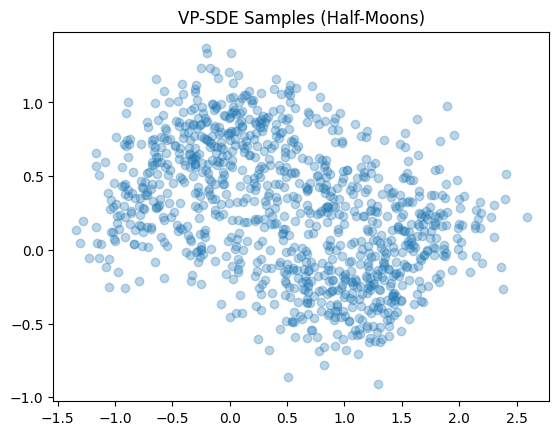

Epoch [100/5000], Loss: 1.5453
Epoch [200/5000], Loss: 1.4423
Epoch [300/5000], Loss: 1.4550
Epoch [400/5000], Loss: 1.3623
Epoch [500/5000], Loss: 1.3272
Epoch [600/5000], Loss: 1.3670
Epoch [700/5000], Loss: 1.3182
Epoch [800/5000], Loss: 1.3151
Epoch [900/5000], Loss: 1.3505
Epoch [1000/5000], Loss: 1.3711
Epoch [1100/5000], Loss: 1.3910
Epoch [1200/5000], Loss: 1.4322
Epoch [1300/5000], Loss: 1.4257
Epoch [1400/5000], Loss: 1.3832
Epoch [1500/5000], Loss: 1.4277
Epoch [1600/5000], Loss: 1.4270
Epoch [1700/5000], Loss: 1.2090
Epoch [1800/5000], Loss: 1.3995
Epoch [1900/5000], Loss: 1.4710
Epoch [2000/5000], Loss: 1.4175
Epoch [2100/5000], Loss: 1.5769
Epoch [2200/5000], Loss: 1.3677
Epoch [2300/5000], Loss: 1.3695
Epoch [2400/5000], Loss: 1.4090
Epoch [2500/5000], Loss: 1.4678
Epoch [2600/5000], Loss: 1.4538
Epoch [2700/5000], Loss: 1.4106
Epoch [2800/5000], Loss: 1.2939
Epoch [2900/5000], Loss: 1.2884
Epoch [3000/5000], Loss: 1.4010
Epoch [3100/5000], Loss: 1.2928
Epoch [3200/5000]

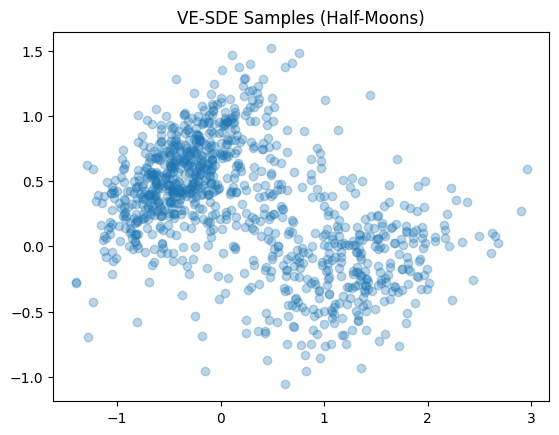

In [ ]:
# train_loop
def train_score_model(sde_type='VP',n_samples = 512, n_epochs=1000, lr=1e-3, batch_size=128,device='cpu'):

    data = get_half_moons_dataset(n_samples=n_samples).to(device)
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # variance preserving
    if sde_type == 'VP':
        sde = VPSDE(beta_min=0.1, beta_max=20.0)
    else:
        # variacne prserving
        sde = VESDE(sigma_min=0.01, sigma_max=5.0)

    # this will serve as the s_θ(x)
    score_model = ScoreNetwork(hidden_dim=64).to(device)
    optimizer = optim.Adam(score_model.parameters(), lr=lr)


    for epoch in range(n_epochs):
      avg_loss = 0.0

      # Each batch is a tuple; since we only have one tensor, we extract it:
      for batch in dataloader:
          x_batch = batch[0]  # batch is a tuple with one element
          loss = loss_fn(score_model, sde, x_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          avg_loss += loss.item()

      avg_loss /= len(dataloader)

      if (epoch + 1) % 100 == 0:
          print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

    return score_model, sde

if __name__ == '__main__':
    if torch.backends.mps.is_available():
      device = torch.device("mps")
    elif torch.cuda.is_available():
      device = torch.device("cuda")
    else:
      device = torch.device("cpu")
      print("Using device:", device)

   # –––––– HYPERPARAMS–––––
    #number of P and C steps are the same (empirical result from paper)
    n_steps = 1000
    n_samples = 1024
    batch_size = 128

    # 1a Train VP SDE
    vp_score_model, vp_sde = train_score_model(
        sde_type='VP',
        n_samples =n_samples,
        n_epochs=5000,
        lr=1e-3,
        batch_size=128,
        device=device
    )

    # 1b Sample
    samples_vp, intermediates_vp = pc_sampler(
        score_model=vp_score_model,
        sde=vp_sde,
        num_steps=n_steps,
        snr=0.15,
        step_size=0.001,
        device=device
    )
    samples_vp = samples_vp.cpu().numpy()

    plt.figure()
    plt.scatter(samples_vp[:, 0], samples_vp[:, 1], alpha=0.3)
    plt.title("VP-SDE Samples (Half-Moons)")
    plt.show()

    # 2. VE SDE
    ve_score_model, ve_sde = train_score_model(
        sde_type='VE',
        n_samples =n_samples,
        n_epochs=5000,
        lr=1e-3,
        batch_size=128,
        device=device
    )

    # Sample
    samples_ve,intermediates_ve = pc_sampler(
        score_model=ve_score_model,
        sde=ve_sde,
        num_steps=n_steps,
        snr=0.15,
        step_size=0.001,
        device=device
    )
    samples_ve = samples_ve.cpu().numpy()

    plt.figure()
    plt.scatter(samples_ve[:, 0], samples_ve[:, 1], alpha=0.3)
    plt.title("VE-SDE Samples (Half-Moons)")
    plt.show()


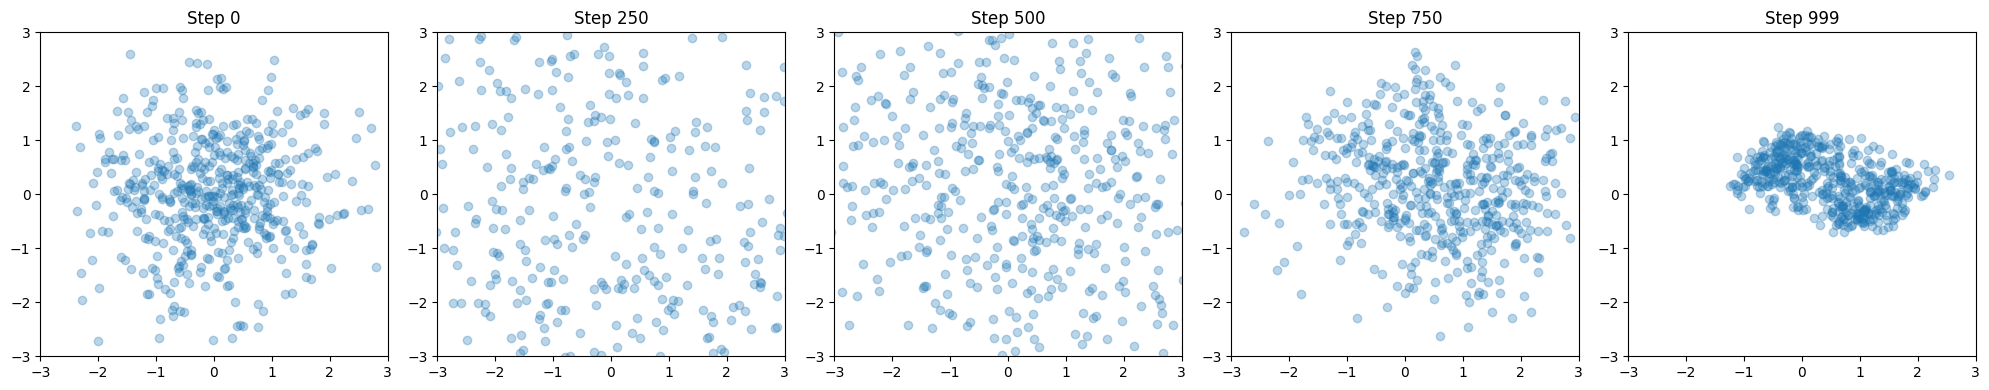

In [ ]:
@torch.no_grad()
def pc_sampler_with_intermediate(score_model, sde, num_steps=500, snr=0.16, step_size=0.01, device='cpu'):
    """
    PC sampler with intermediate state recording. This function records and returns
    the sample states at 5 proportional time steps along the reverse SDE trajectory.
    """
    # Start from the SDE's prior distribution at t=1
    x = sde.prior_sampling((512, 2)).to(device)  # e.g. 1000 samples
    t_values = torch.linspace(1, 0, num_steps, device=device)

    # Indices to save intermediate steps (5 steps including initial and final)
    record_steps = set([0, num_steps//4, num_steps//2, 3*num_steps//4, num_steps-1])
    intermediates = {}

    for i in range(num_steps):
        t = t_values[i]

        # ---- PREDICTOR STEP (Euler-Maruyama) ----
        drift, diffusion = sde.sde(x, t)
        dt = -1.0 / num_steps  # negative because we integrate backwards from t=1 to t=0
        dt_tensor = torch.tensor(dt, device=device, dtype=x.dtype)
        x = x + drift * dt_tensor + diffusion * torch.sqrt(torch.abs(dt_tensor)) * torch.randn_like(x)

        # ---- CORRECTOR STEP (Langevin MCMC) ----
        t_for_score = t.clone().detach().unsqueeze(0).expand(x.size(0))
        score = score_model(x, t_for_score)

        grad_norm = torch.mean(torch.sqrt(torch.sum(score**2, dim=1)), dim=0)
        param_norm = torch.mean(torch.sqrt(torch.sum(x**2, dim=1)), dim=0)
        epsilon = 2 * (snr * param_norm / (1e-6+grad_norm))**2
        epsilon = torch.clamp(epsilon, max=0.01)
        noise = torch.randn_like(x)
        x = x + epsilon * score + torch.sqrt(2 * epsilon) * noise

        # Record intermediate sample if step matches
        if i in record_steps:
            intermediates[i] = x.clone().cpu().numpy()

    return x, intermediates

samples, intermediates = pc_sampler_with_intermediate(
    score_model=vp_score_model,
    sde=vp_sde,
    num_steps=1000,
    snr=0.15,
    step_size=0.001,
    device=device
)
# Assuming `intermediates` is the dictionary returned by pc_sampler_with_intermediate
step_keys = sorted(intermediates.keys())  # keys in order (e.g., 0, 125, 250, 375, 499)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for ax, key in zip(axs, step_keys):
    pts = intermediates[key]
    ax.scatter(pts[:, 0], pts[:, 1], alpha=0.3)
    ax.set_title(f"Step {key}")

    # Optionally set limits to have a consistent view across subplots
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
plt.tight_layout()
plt.show()

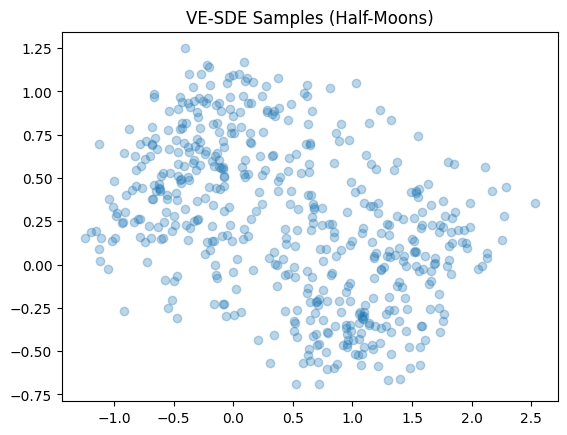

In [ ]:
plt.figure()
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3)
plt.title("VP-SDE Samples (Half-Moons)")
plt.show()

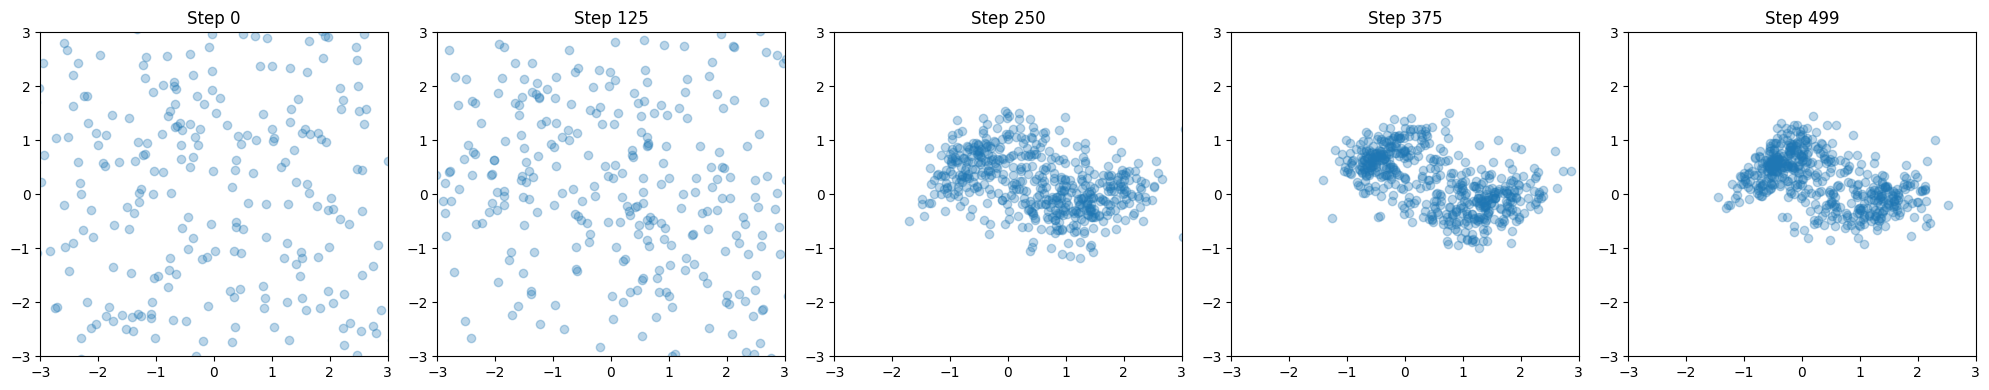

In [ ]:

samples, intermediates = pc_sampler_with_intermediate(
    score_model=ve_score_model,
    sde=ve_sde,
    num_steps=500,
    snr=0.15,
    step_size=0.001,
    device=device
)
# Assuming `intermediates` is the dictionary returned by pc_sampler_with_intermediate
step_keys = sorted(intermediates.keys())  # keys in order (e.g., 0, 125, 250, 375, 499)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for ax, key in zip(axs, step_keys):
    pts = intermediates[key]
    ax.scatter(pts[:, 0], pts[:, 1], alpha=0.3)
    ax.set_title(f"Step {key}")

    # Optionally set limits to have a consistent view across subplots
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
plt.tight_layout()
plt.show()

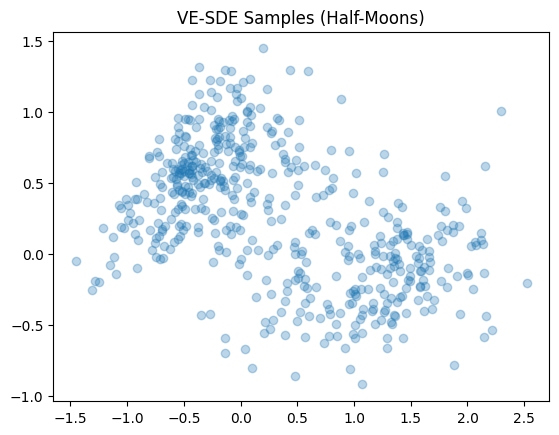

In [ ]:
plt.figure()
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3)
plt.title("VE-SDE Samples (Half-Moons)")
plt.show()

Using device: cuda
Epoch [100/1000], Loss: 75.2203
Epoch [200/1000], Loss: 67.7905
Epoch [300/1000], Loss: 76.4541
Epoch [400/1000], Loss: 105.3721
Epoch [500/1000], Loss: 55.9234
Epoch [600/1000], Loss: 67.2117
Epoch [700/1000], Loss: 99.7487
Epoch [800/1000], Loss: 73.0576
Epoch [900/1000], Loss: 91.1089
Epoch [1000/1000], Loss: 93.8521


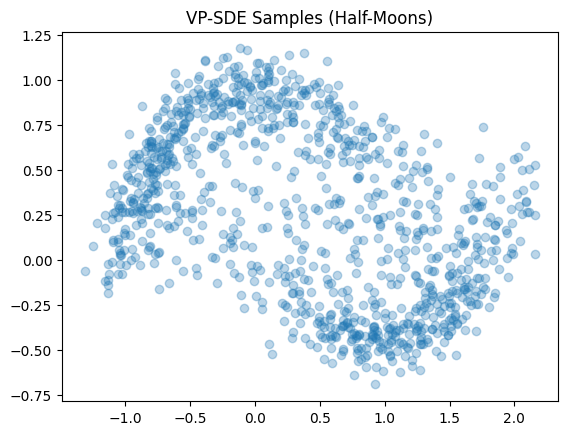

Epoch [100/1000], Loss: 1.3710
Epoch [200/1000], Loss: 1.3619
Epoch [300/1000], Loss: 1.3160
Epoch [400/1000], Loss: 1.2900
Epoch [500/1000], Loss: 1.2947
Epoch [600/1000], Loss: 1.2784
Epoch [700/1000], Loss: 1.2967
Epoch [800/1000], Loss: 1.2764
Epoch [900/1000], Loss: 1.2633
Epoch [1000/1000], Loss: 1.2209


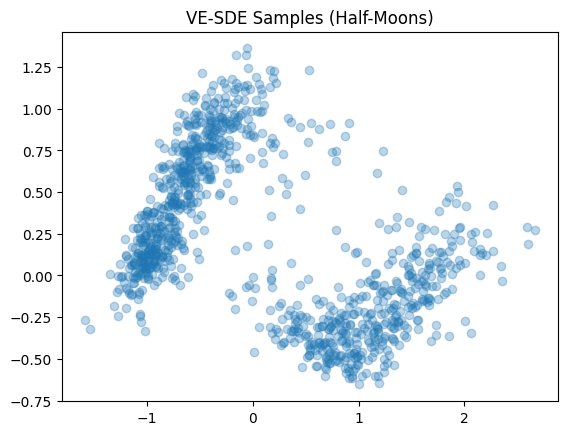

In [ ]:
# train_loop
def train_score_model(sde_type='VP',n_samples = 512, n_epochs=1000, lr=1e-3, batch_size=128,device='cpu'):

    data = get_half_moons_dataset(n_samples=n_samples).to(device)
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    if sde_type == 'VP':
        sde = VPSDE(beta_min=0.1, beta_max=20.0)
    else:
        sde = VESDE(sigma_min=0.01, sigma_max=5.0)

    # this will serve as the s_θ(x)
    score_model = ScoreNetwork(hidden_dim=64).to(device)
    optimizer = optim.Adam(score_model.parameters(), lr=lr)


    for epoch in range(n_epochs):
      avg_loss = 0.0

      # Each batch is a tuple; since we only have one tensor, we extract it:
      for batch in dataloader:
          x_batch = batch[0]  # batch is a tuple with one element
          loss = loss_fn(score_model, sde, x_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          avg_loss += loss.item()

      avg_loss /= len(dataloader)

      if (epoch + 1) % 100 == 0:
          print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

    return score_model, sde

if __name__ == '__main__':
    if torch.backends.mps.is_available():
      device = torch.device("mps")
    elif torch.cuda.is_available():
      device = torch.device("cuda")
    else:
      device = torch.device("cpu")
    print("Using device:", device)

    #number of P and C steps are the same (empirical result from paper)
    n_steps = 1000
    # we choose half-moon dataset to be 10240 sampels
    n_samples = 10240
    b_size = 256
    n_epochs = 1000

    # 1a Train VP SDE
    vp_score_model, vp_sde = train_score_model(
        sde_type='VP',
        n_samples =n_samples,
        n_epochs=n_epochs,
        lr=1e-3,
        batch_size=b_size,
        device=device
    )

    # 1b Sample
    samples_vp = pc_sampler(
        score_model=vp_score_model,
        sde=vp_sde,
        num_steps=n_steps,
        snr=0.15,
        step_size=0.001,
        device=device
    )
    samples_vp = samples_vp.cpu().numpy()

    plt.figure()
    plt.scatter(samples_vp[:, 0], samples_vp[:, 1], alpha=0.3)
    plt.title("VP-SDE Samples (Half-Moons)")
    plt.show()

    # 2. VE SDE
    ve_score_model, ve_sde = train_score_model(
        sde_type='VE',
        n_samples =n_samples,
        n_epochs=n_epochs,
        lr=1e-3,
        batch_size=b_size,
        device=device
    )

    # Sample
    samples_ve = pc_sampler(
        score_model=ve_score_model,
        sde=ve_sde,
        num_steps=n_steps,
        snr=0.15,
        step_size=0.001,
        device=device
    )
    samples_ve = samples_ve.cpu().numpy()

    plt.figure()
    plt.scatter(samples_ve[:, 0], samples_ve[:, 1], alpha=0.3)
    plt.title("VE-SDE Samples (Half-Moons)")
    plt.show()


## References:

Swiss-roll dataset implementing DSM:
https://colab.research.google.com/drive/1hzk-V_yby0KiNCKLBnu7WvXUhZg4-RKg#scrollTo=l8C8jlRk2Yi0 \
accompanying GITHUB:

https://github.com/CW-Huang/sdeflow-light?tab=readme-ov-file
\
second reference: \
https://github.com/acids-ircam/diffusion_models/blob/main/diffusion_01_score.ipynb